In [1]:
from dask.distributed import Client, progress
import dask.array as da
import numpy as np
import scipy
client = Client(processes=False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.0.113:8787/status,
Dashboard: http://192.168.0.113:8787/status,Workers: 1
Total threads: 8,Total memory: 31.04 GiB
Status: running,Using processes: False
Comm: inproc://192.168.0.113/6319/1,Workers: 1
Dashboard: http://192.168.0.113:8787/status,Total threads: 8
Started: Just now,Total memory: 31.04 GiB
Comm: inproc://192.168.0.113/6319/4,Total threads: 8
Dashboard: http://192.168.0.113:45185/status,Memory: 31.04 GiB
Nanny: None,


Overlapping Operations
======================

Some operations depend on neigbourding values. For exemple derivatives, sliding sum, image filter.

For that there is `overlap` and `map_overlap`.  
It add a border to each chunks before mapping function on each chunks.  

![](https://docs.dask.org/en/stable/_images/overlapping-neighbors.svg)

It does so in all dimension, including diagonals:

![](https://docs.dask.org/en/stable/_images/overlapping-blocks.svg)

In [2]:
x = da.from_array(np.arange(100).reshape((10, 10)), chunks=(5, 2))
x

dask.array<array, shape=(10, 10), dtype=int64, chunksize=(5, 2), chunktype=numpy.ndarray>

In [3]:
x.compute()

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [4]:
g = da.overlap.overlap(x, depth=(1, 1), boundary=("reflect", -100)) # "periodic" is also defined
g

dask.array<getitem, shape=(14, 20), dtype=int64, chunksize=(7, 4), chunktype=numpy.ndarray>

In [5]:
g.compute()[:, :10]

array([[-100,    0,    1,    2,    1,    2,    3,    4,    3,    4],
       [-100,    0,    1,    2,    1,    2,    3,    4,    3,    4],
       [-100,   10,   11,   12,   11,   12,   13,   14,   13,   14],
       [-100,   20,   21,   22,   21,   22,   23,   24,   23,   24],
       [-100,   30,   31,   32,   31,   32,   33,   34,   33,   34],
       [-100,   40,   41,   42,   41,   42,   43,   44,   43,   44],
       [-100,   50,   51,   52,   51,   52,   53,   54,   53,   54],
       [-100,   40,   41,   42,   41,   42,   43,   44,   43,   44],
       [-100,   50,   51,   52,   51,   52,   53,   54,   53,   54],
       [-100,   60,   61,   62,   61,   62,   63,   64,   63,   64],
       [-100,   70,   71,   72,   71,   72,   73,   74,   73,   74],
       [-100,   80,   81,   82,   81,   82,   83,   84,   83,   84],
       [-100,   90,   91,   92,   91,   92,   93,   94,   93,   94],
       [-100,   90,   91,   92,   91,   92,   93,   94,   93,   94]])

In [6]:
def convolve2d(arr):
    filter = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
    return scipy.signal.convolve2d(arr, filter, mode="same")

diff = g.map_blocks(convolve2d)
diff

dask.array<convolve2d, shape=(14, 20), dtype=int64, chunksize=(7, 4), chunktype=numpy.ndarray>

In [7]:
diff.blocks[0, 1].compute()

array([[  -1,   -2,   -3,   -9],
       [  10,   10,   10,    5],
       [ -10,    0,    0,  -15],
       [ -20,    0,    0,  -25],
       [ -30,    0,    0,  -35],
       [ -40,    0,    0,  -45],
       [-111,  -62,  -63, -119]])

In [8]:
trimmed = da.overlap.trim_overlap(diff, (1, 1))
trimmed

dask.array<_trim, shape=(12, 12), dtype=int64, chunksize=(6, 3), chunktype=numpy.ndarray>

In [13]:
trimmed.blocks[0, 1].compute()

array([[-2, -3],
       [10, 10],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0]])

In [14]:
trimmed.blocks[0, 0].compute()

array([[ 300,  -99,   -1],
       [ 200,  -89,   10],
       [ 210, -109,    0],
       [ 220, -119,    0],
       [ 230, -129,    0],
       [ 240, -139,    0]])

In [15]:
trimmed.compute()

array([[ 300,  -99,   -1,   -2,   -3,   -4,   -5,   -6,   -7,   -8, -119,
         309],
       [ 200,  -89,   10,   10,   10,   10,   10,   10,   10,   10, -100,
         209],
       [ 210, -109,    0,    0,    0,    0,    0,    0,    0,    0, -120,
         219],
       [ 220, -119,    0,    0,    0,    0,    0,    0,    0,    0, -130,
         229],
       [ 230, -129,    0,    0,    0,    0,    0,    0,    0,    0, -140,
         239],
       [ 240, -139,    0,    0,    0,    0,    0,    0,    0,    0, -150,
         249],
       [ 250, -149,    0,    0,    0,    0,    0,    0,    0,    0, -160,
         259],
       [ 260, -159,    0,    0,    0,    0,    0,    0,    0,    0, -170,
         269],
       [ 270, -169,    0,    0,    0,    0,    0,    0,    0,    0, -180,
         279],
       [ 280, -179,    0,    0,    0,    0,    0,    0,    0,    0, -190,
         289],
       [ 290, -199,  -10,  -10,  -10,  -10,  -10,  -10,  -10,  -10, -210,
         299],
       [ 390, -279,  

## Exercise: gradient

We define a function on a 2d plane. Then compute the derivatives.

$\frac{df(x, y)}{dx} = \frac{f(x + dx, y) - f(x - dx, y)}{2 dx}$


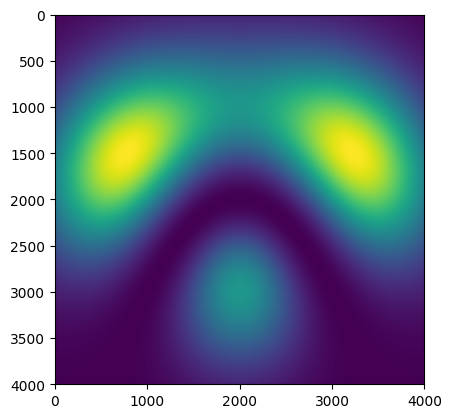

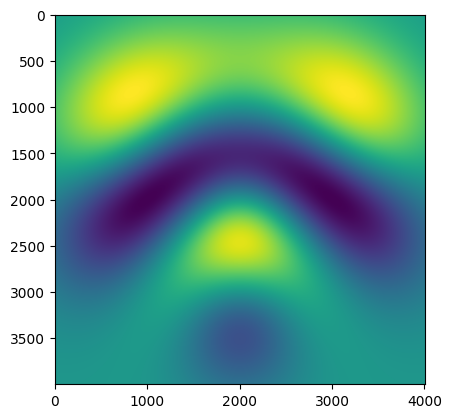

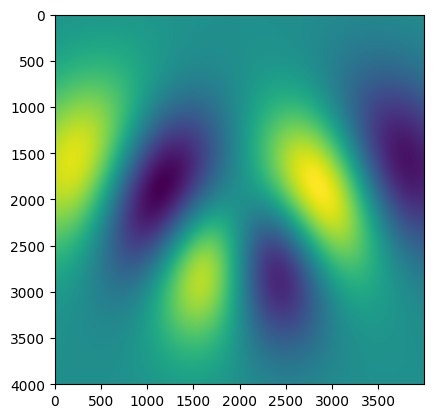

In [16]:
import matplotlib.pyplot as plt
ts = np.linspace(-2, 2, 4001)
xs, ys = np.meshgrid(ts, ts)

func = (xs**2 - ys) **2 * np.exp(-(xs**2 + ys**2))

dx = np.diff(func, axis=0) / 0.001
dy = np.diff(func, axis=1) / 0.001

plt.imshow(func)
plt.show()
plt.imshow(dx)
plt.show()
plt.imshow(dy)

In [19]:
ts = da.linspace(-2, 2, 4001, chunks=(1000,))
xs, ys = da.meshgrid(ts, ts)

func = (xs**2 - ys) **2 * np.exp(-(xs**2 + ys**2))

dx = np.diff(func, axis=0) / 0.001
dy = np.diff(func, axis=0) / 0.001

dx.visualize()

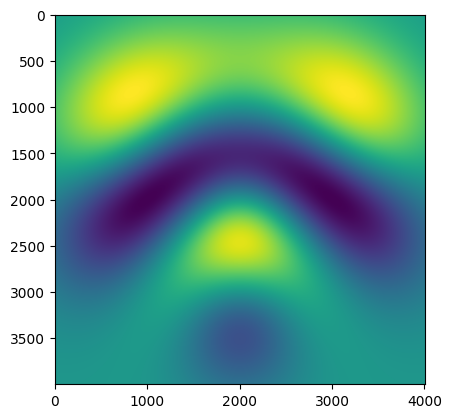

In [21]:
plt.imshow(dx.compute())